In [1]:
import pandas as pd
import numpy as np
import psycopg2 as pg
#import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
%matplotlib inline

from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.model_selection import cross_validate, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, precision_score, recall_score
from sklearn.metrics import  roc_curve, f1_score, auc, precision_recall_curve
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from ipywidgets import interactive, FloatSlider
import pickle

import warnings
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)

Using TensorFlow backend.


### Query Data from Postgresql

In [2]:
# Connect to my AWS server
params = {
    'host': '3.130.17.136',
    'user': 'ubuntu',
    'port': 5432
}
connection = pg.connect(**params, dbname='project3')
cursor = connection.cursor()

In [3]:
# Query world literacy data using Postgresql
literacy_df = pd.read_sql("""

WITH latest_info AS(
SELECT entity, MAX(year) AS latest_year
FROM world_literacy
GROUP BY entity)

SELECT world_literacy.entity, world_literacy.literacy_rates FROM latest_info
INNER JOIN world_literacy
ON latest_info.latest_year = world_literacy.year 
AND latest_info.entity = world_literacy.entity
ORDER BY latest_info.entity

""", connection)

In [4]:
# Change the string of contries' name to upper case
literacy_df['entity'] = literacy_df['entity'].str.upper()

In [5]:
# Query US Visa Application data using Postgresql. Also import the 5 percentile, median and 95 percentile of wage
visa_df = pd.read_sql("""
SELECT us_perm_visa.*, p5_job_category_wage, p50_job_category_wage, p85_job_category_wage
FROM us_perm_visa JOIN
     (SELECT job_category,
             PERCENTILE_CONT(0.05) WITHIN GROUP (ORDER BY scaled_wage) as p5_job_category_wage,
             PERCENTILE_CONT(0.50) WITHIN GROUP (ORDER BY scaled_wage) as p50_job_category_wage,
             PERCENTILE_CONT(0.85) WITHIN GROUP (ORDER BY scaled_wage) as p85_job_category_wage
      from us_perm_visa
      GROUP BY job_category
     ) que_tab
     ON us_perm_visa.job_category = que_tab.job_category
""", connection).drop(columns=['index'])

### Feature Engineering & Data Preparation for Modeling

In [6]:
# These are the engineered features to improve the predication score of models
lo_weight = 1
visa_df['wage_lower_deviation'] = visa_df.apply(lambda x: ((x.scaled_wage-x.p5_job_category_wage)
                                                           /x.p5_job_category_wage) * lo_weight, axis=1)
up_weight = 1
visa_df['wage_upper_deviation'] = visa_df.apply(lambda x: ((x.p85_job_category_wage-x.scaled_wage)
                                                           /x.p85_job_category_wage) * up_weight, axis=1)
visa_df['wage_in_range_value'] = visa_df.apply(lambda x: min(x.wage_lower_deviation,x.wage_upper_deviation), axis=1)
visa_df['category_wage_ratio'] = visa_df.apply(lambda x: ((x.scaled_wage-x.p50_job_category_wage)
                                                          /x.p50_job_category_wage), axis=1)

In [7]:
# Combined both US Visa Application data and world literacy data
visa_df = pd.merge(visa_df, literacy_df, left_on = ['country_of_citizenship'],
                   right_on = ['entity']).drop(columns=['entity'])

In [8]:
# Filtered out 'Certified-Expired' and 'Withdrewn' data
visa_df = visa_df[(visa_df['case_status']=='Certified') | (visa_df['case_status']=='Denied')]

In [9]:
# Export data to be used for data visualization
visa_df.to_csv('project3_final_modeling_data.csv')

In [10]:
# Convert the classes to 1 and 0 for further modeling
visa_df['case_status'] = visa_df.case_status.transform(lambda x: 1 if x=='Certified' else 0)

In [11]:
# Create dummies for all categorical features
visa_df = pd.get_dummies(visa_df, columns=['job_category', 'job_level','wage_period','class_of_admission','education'])

In [12]:
# Drop features which will not be used for modeling
visa_df = visa_df.drop(columns=(['education_Other','country_of_citizenship','decision_date','work_city',
                                 'job_state','job_title','job_category_Unknown','wage','job_level_Level II',
                                 'wage_period_Bi-Weekly','p5_job_category_wage','p50_job_category_wage',
                                 'p85_job_category_wage','wage_lower_deviation','wage_upper_deviation',
                                 'wage_in_range_value']))
#visa_df = visa_df.drop(columns=(['education_Other','country_of_citizenship','decision_date','work_city',
#                                 'job_state','job_title','job_category_Unknown','wage','job_level_Level II',
#                                 'wage_period_Bi-Weekly','p5_job_category_wage','p50_job_category_wage',
#                                 'p85_job_category_wage','wage_lower_deviation','wage_upper_deviation',
#                                 'category_wage_ratio']))
#visa_df = visa_df.drop(columns=(['education_Other','country_of_citizenship','decision_date','work_city',
#                                 'job_state','job_title','job_category_Unknown','wage','job_level_Level II',
#                                 'wage_period_Bi-Weekly','p5_job_category_wage','p50_job_category_wage',
#                                 'p85_job_category_wage','wage_in_range_value','category_wage_ratio']))

In [13]:
visa_df.head()

,case_status,scaled_wage,category_wage_ratio,literacy_rates,job_category_Education,job_category_Food Preparation,job_category_Management,job_category_Non-STEM Professional,job_category_STEM,job_category_Sales,...,class_of_admission_TPS,class_of_admission_V-2,class_of_admission_VWB,class_of_admission_VWT,education_Associate's,education_Bachelor's,education_Doctorate,education_High School,education_Master's,education_None
0,1,92500.0,-0.092634,72.225304,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,1,99424.0,-0.024714,72.225304,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,1,69600.0,-0.317268,72.225304,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
5,1,136829.0,0.342206,72.225304,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
8,1,90813.0,-0.109182,72.225304,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


### Train Test Split and Oversampling

In [14]:
y = visa_df.iloc[:,0]
X = visa_df.iloc[:,1:]

In [15]:
# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=77)
print('Train data: ',sorted(Counter(y_train).items()))
print('Test data: ',sorted(Counter(y_test).items()))

Train data:  [(0, 6554), (1, 73481)]
Test data:  [(0, 2809), (1, 31493)]


In [16]:
# Scale data using StandardScaler
scalar = StandardScaler()
X_train_scaled = scalar.fit_transform(X_train)
X_test_scaled = scalar.transform(X_test)

In [ ]:
# Apply undersampling due to imbalanced classes
y_train2 = y_train.copy()
rus = RandomUnderSampler(random_state=77)
rus_resample = RandomUnderSampler(random_state=77)
X_train, y_train = rus.fit_resample(X_train, y_train)
X_train_scaled, y_train2 = rus_resample.fit_resample(X_train_scaled, y_train2)
print('Train data: ',sorted(Counter(y_train).items()))
print('Test data: ',sorted(Counter(y_test).items()))

In [ ]:
# Apply simple overampling due to imbalanced classes
y_train2 = y_train.copy()
ros = RandomOverSampler(random_state=77)
ros_resample = RandomOverSampler(random_state=77)
X_train, y_train = ros.fit_resample(X_train, y_train)
X_train_scaled, y_train2 = ros_resample.fit_resample(X_train_scaled, y_train2)
print('Train data: ',sorted(Counter(y_train).items()))
print('Test data: ',sorted(Counter(y_test).items()))

In [ ]:
# Apply SMOTE due to imbalanced classes
y_train2 = y_train.copy()
smote = SMOTE(random_state=77)
smote_resample = SMOTE(random_state=77)
X_train, y_train = smote.fit_resample(X_train, y_train)
X_train_scaled, y_train2 = smote_resample.fit_resample(X_train_scaled, y_train2)
print('Train data: ',sorted(Counter(y_train).items()))
print('Test data: ',sorted(Counter(y_test).items()))

In [17]:
# Apply ADAYSN due to imbalanced classes
y_train2 = y_train.copy()
adaysn = ADASYN(random_state=77)
adaysn_resample = ADASYN(random_state=77)
X_train, y_train = adaysn.fit_resample(X_train, y_train)
X_train_scaled, y_train2 = adaysn_resample.fit_resample(X_train_scaled, y_train2)
print('Train data: ',sorted(Counter(y_train).items()))
print('Test data: ',sorted(Counter(y_test).items()))

Train data:  [(0, 73992), (1, 73481)]
Test data:  [(0, 2809), (1, 31493)]


In [18]:
# Use StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=77, shuffle=True)

### Cross Validate Checks of all Models

In [ ]:
logit_cv = cross_validate(LogisticRegression(random_state=77), X_train_scaled, y_train2, cv=skf, 
                              scoring=('accuracy', 'f1', 'precision', 'recall','roc_auc'), 
                              return_train_score=True)
logit_cv

In [ ]:
knn_cv = cross_validate(KNeighborsClassifier(n_neighbors=3), X_train_scaled, y_train2, cv=skf,
                            scoring=('accuracy','f1', 'precision', 'recall', 'roc_auc'),
                            return_train_score=True)
knn_cv

In [ ]:
rf_cv = cross_validate(RandomForestClassifier(random_state=77), X_train, y_train, cv=skf, 
                              scoring=('accuracy', 'f1', 'precision', 'recall','roc_auc'), 
                              return_train_score=True)
rf_cv

In [ ]:
bernoulliNB_cv = cross_validate(BernoulliNB(alpha=1.0, binarize=0.0), X_train, y_train, cv=skf, 
                              scoring=('accuracy','f1', 'precision', 'recall','roc_auc'), return_train_score=True)
bernoulliNB_cv

In [ ]:
svc_linear_scores = cross_validate(SVC(kernel='linear', C=1, random_state=77), X_train_scaled, y_train2, cv=5, 
                              scoring=('accuracy','f1', 'precision', 'recall','roc_auc'), return_train_score=True)
svc_linear_scores

In [ ]:
svc_rbf_scores = cross_validate(SVC(kernel='rbf', C=1, random_state=77), X_train_scaled, y_train2, cv=skf, 
                              scoring=('accuracy','f1', 'precision', 'recall','roc_auc'), return_train_score=True)
svc_rbf_scores

### GridSearchCV - KNN

In [ ]:
# Choose the type of classifier. 
knn_clf = KNeighborsClassifier()

# Choose some parameter combinations to try
parameters = {'n_neighbors': [3, 5, 7], 
              'weights': ['uniform', 'distance']
             }
# Type of scoring used to compare parameter combinations
scorer = make_scorer(roc_auc_score, precision_score, recall_score)

# Run the grid search
grid_obj = GridSearchCV(knn_clf, parameters, scoring=(scorer), cv=skf)
grid_obj = grid_obj.fit(X_train_scaled, y_train2)

# Set the knn_clf to the best combination of parameters
knn_clf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
knn_clf.fit(X_train_scaled, y_train2)

In [ ]:
knn_predictions = knn_clf.predict(X_test_scaled)
print('Accuracy using GridsearchCV(KNN): ', accuracy_score(y_test, knn_predictions))
print('Precision using GridsearchCV(KNN): ', precision_score(y_test, knn_predictions))
print('Recall using GridsearchCV(KNN): ', recall_score(y_test, knn_predictions))
print('F1 using GridsearchCV(KNN): ', f1_score(y_test, knn_predictions))
print('ROC AUC using GridsearchCV(KNN): ', roc_auc_score(y_test, knn_clf.predict_proba(X_test_scaled)[:,1]))

### GridSearchCV - Random Forest

In [ ]:
# Choose the type of classifier. 
rf_clf = RandomForestClassifier(random_state=77)

# Choose some parameter combinations to try
parameters = {'n_estimators': [80, 100, 120], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 5, 8], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1, 5, 8]
             }
# Type of scoring used to compare parameter combinations
scorer = make_scorer(roc_auc_score, precision_score, recall_score)

# Run the grid search
grid_obj = GridSearchCV(rf_clf, parameters, scoring=(scorer), cv=skf)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the rf_clf to the best combination of parameters
rf_clf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
rf_clf.fit(X_train, y_train)

In [ ]:
rf_predictions = rf_clf.predict(X_test)
print('Accuracy using GridsearchCV(Random_Forest): ', accuracy_score(y_test, rf_predictions))
print('Precision using GridsearchCV(Random_Forest): ', precision_score(y_test, rf_predictions))
print('Recall using GridsearchCV(Random_Forest): ', recall_score(y_test, rf_predictions))
print('F1 using GridsearchCV(Random_Forest): ', f1_score(y_test, rf_predictions))
print('ROC AUC using GridsearchCV(Random_Forest): ', roc_auc_score(y_test, rf_clf.predict_proba(X_test)[:,1]))

### GridSearchCV - Logistic Regression

In [ ]:
logreg = LogisticRegression(random_state=77)

parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
              'penalty':['l1','l2']}

scorer = make_scorer(roc_auc_score, precision_score, recall_score)

grid_obj = GridSearchCV(logreg, parameters, scoring=scorer, cv=skf)
grid_obj = grid_obj.fit(X_train_scaled,y_train2)

logreg = grid_obj.best_estimator_

logreg.fit(X_train_scaled, y_train2)

In [ ]:
logit_predictions = logreg.predict(X_test_scaled)
print('Accuracy using GridsearchCV(Logistic Regression): ', accuracy_score(y_test, logit_predictions))
print('Precision using GridsearchCV(Logistic Regression): ', precision_score(y_test, logit_predictions))
print('Recall using GridsearchCV(Logistic Regression): ', recall_score(y_test, logit_predictions))
print('F1 using GridsearchCV(Logistic Regression): ', f1_score(y_test, logit_predictions))
print('ROC AUC using GridsearchCV(Logistic Regression): ', roc_auc_score(y_test, logreg.predict_proba(X_test_scaled)[:,1]))

### KNN - Best Hyperparameters

In [ ]:
#knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', # Undersampling - upper and lower dev
#                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
#                     weights='uniform')

#knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', # Undersampling - wage in range value
#                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
#                     weights='uniform')

#knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', # Oversampling - wage in range value
#                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
#                     weights='distance')

knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', # SMOTE - Category Wage Ratio
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='distance')
knn.fit(X_train_scaled,y_train2)

In [ ]:
knn_accuracy = accuracy_score(y_test,knn.predict(X_test_scaled))
knn_ll = log_loss(y_test,knn.predict(X_test_scaled))
knn_precision = precision_score(y_test,knn.predict(X_test_scaled))
knn_f1 = f1_score(y_test,knn.predict(X_test_scaled))
knn_recall = recall_score(y_test,knn.predict(X_test_scaled))
knn_roc_auc = roc_auc_score(y_test,knn.predict_proba(X_test_scaled)[:,1])
print('<KNN Scores>')
print('Accuracy: {}\nLog Loss: {}\nPrecision: {}\nF1: {}\nRecall :{}\nROC AUC: {}'
      .format(knn_accuracy, knn_ll, knn_precision, knn_f1, knn_recall, knn_roc_auc))

fpr, tpr, thresholds = roc_curve(y_test, knn.predict_proba(X_test_scaled)[:,1])
plt.plot(fpr, tpr,lw=2,c='red')
plt.plot([0,1],[0,1],c='blue',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - KNN');

In [ ]:
knn_confusion = confusion_matrix(y_test, knn.predict(X_test_scaled))
plt.figure(dpi=100)
sns.heatmap(knn_confusion, cmap=plt.cm.Reds, annot=True, square=True,
           xticklabels = ['Not Certified', 'Certified'],
           yticklabels = ['Not Certified', 'Certified'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('KNN Confusion Matrix');

### Logistic Regression - Best Hyperparameters

In [ ]:
#logit = LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,# Undersampling - upper and lower dev
#                   intercept_scaling=1, l1_ratio=None, max_iter=100,
#                   multi_class='warn', n_jobs=None, penalty='l1',
#                   random_state=77, solver='warn', tol=0.0001, verbose=0,
#                   warm_start=False)

#logit = LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True, # Undersampling - wage in range value
#                   intercept_scaling=1, l1_ratio=None, max_iter=100,
#                   multi_class='warn', n_jobs=None, penalty='l1',
#                   random_state=77, solver='warn', tol=0.0001, verbose=0,
#                   warm_start=False)

#logit = LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True, # Oversampling - wage in range value
#                   intercept_scaling=1, l1_ratio=None, max_iter=100,
#                   multi_class='warn', n_jobs=None, penalty='l1',
#                   random_state=77, solver='warn', tol=0.0001, verbose=0,
#                   warm_start=False)

#logit = LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True, # SMOTE - Category Wage Ratio
#                   intercept_scaling=1, l1_ratio=None, max_iter=100,
#                   multi_class='warn', n_jobs=None, penalty='l1',
#                   random_state=77, solver='warn', tol=0.0001, verbose=0,
#                   warm_start=False)

logit = LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True, # ADASYN - Category Wage Ratio
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=77, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

logit.fit(X_train_scaled,y_train2)

In [ ]:
logit_accuracy = accuracy_score(y_test,logit.predict(X_test_scaled))
logit_ll = log_loss(y_test,logit.predict(X_test_scaled))
logit_precision = precision_score(y_test,logit.predict(X_test_scaled))
logit_f1 = f1_score(y_test,logit.predict(X_test_scaled))
logit_recall = recall_score(y_test,logit.predict(X_test_scaled))
logit_roc_auc = roc_auc_score(y_test,logit.predict_proba(X_test_scaled)[:,1])
print('<Logistc Regression Scores>')
print('Accuracy: {}\nLog Loss: {}\nPrecision: {}\nF1: {}\nRecall :{}\nROC AUC: {}'
      .format(logit_accuracy, logit_ll, logit_precision, logit_f1, logit_recall, logit_roc_auc))

fpr, tpr, thresholds = roc_curve(y_test, logit.predict_proba(X_test_scaled)[:,1])
plt.plot(fpr, tpr,lw=2,c='red')
plt.plot([0,1],[0,1],c='blue',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Logistic Regression');

In [ ]:
logit_confusion = confusion_matrix(y_test, logit.predict(X_test_scaled))
plt.figure(dpi=100)
sns.heatmap(logit_confusion, cmap=plt.cm.Greens, annot=True, square=True,
           xticklabels = ['Not Certified', 'Certified'],
           yticklabels = ['Not Certified', 'Certified'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix');

### Random Forest - Best Hyperparameters

In [19]:
#rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', # Undersampling - upper and lower dev
#                       max_depth=8, max_features='sqrt', max_leaf_nodes=None,
#                       min_impurity_decrease=0.0, min_impurity_split=None,
#                       min_samples_leaf=1, min_samples_split=3,
#                       min_weight_fraction_leaf=0.0, n_estimators=120,
#                       n_jobs=None, oob_score=False, random_state=77, verbose=0,
#                       warm_start=False)

#rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', # Undersampling - wage in range value
#                       max_depth=8, max_features='sqrt', max_leaf_nodes=None,
#                       min_impurity_decrease=0.0, min_impurity_split=None,
#                       min_samples_leaf=1, min_samples_split=5,
#                       min_weight_fraction_leaf=0.0, n_estimators=100,
#                       n_jobs=None, oob_score=False, random_state=77, verbose=0,
#                       warm_start=False)

#rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', # Oversampling - wage in range value
#                       max_depth=8, max_features='sqrt', max_leaf_nodes=None,
#                       min_impurity_decrease=0.0, min_impurity_split=None,
#                       min_samples_leaf=1, min_samples_split=2,
#                       min_weight_fraction_leaf=0.0, n_estimators=80,
#                       n_jobs=None, oob_score=False, random_state=77, verbose=0,
#                       warm_start=False)

#rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', # SMOTE - Category Wage Ratio
#                       max_depth=8, max_features='sqrt', max_leaf_nodes=None,
#                       min_impurity_decrease=0.0, min_impurity_split=None,
#                       min_samples_leaf=1, min_samples_split=2,
#                       min_weight_fraction_leaf=0.0, n_estimators=120,
#                       n_jobs=None, oob_score=False, random_state=77, verbose=0,
#                       warm_start=False)

#rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', # ADASYN - - upper and lower dev
#                       max_depth=8, max_features='sqrt', max_leaf_nodes=None,
#                       min_impurity_decrease=0.0, min_impurity_split=None,
#                       min_samples_leaf=1, min_samples_split=3,
#                       min_weight_fraction_leaf=0.0, n_estimators=120,
#                       n_jobs=None, oob_score=False, random_state=77, verbose=0,
#                       warm_start=False)

#rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', # ADASYN - Category Wage Ratio
#                       max_depth=8, max_features='sqrt', max_leaf_nodes=None,
#                       min_impurity_decrease=0.0, min_impurity_split=None,
#                       min_samples_leaf=5, min_samples_split=2,
#                       min_weight_fraction_leaf=0.0, n_estimators=100,
#                       n_jobs=None, oob_score=False, random_state=77, verbose=0,
#                       warm_start=False)

rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', # ADASYN - Category Wage Ratio2
                       max_depth=8, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=120,
                       n_jobs=None, oob_score=False, random_state=77, verbose=0,
                       warm_start=False)

rf.fit(X_train,y_train);

<Random Forest Scores>
Accuracy: 0.882339222202787
Log Loss: 4.063906568522184
Precision: 0.9356456065750642
F1: 0.935942608640447
Recall :0.936239799320484
ROC AUC: 0.7145365342902773


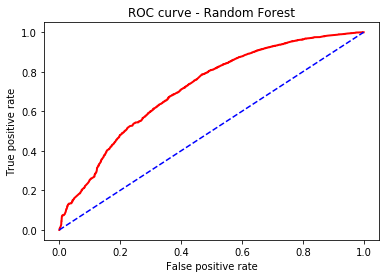

In [20]:
rf_accuracy = accuracy_score(y_test,rf.predict(X_test))
rf_ll = log_loss(y_test,rf.predict(X_test))
rf_precision = precision_score(y_test,rf.predict(X_test))
rf_f1 = f1_score(y_test,rf.predict(X_test))
rf_recall = recall_score(y_test,rf.predict(X_test))
rf_roc_auc = roc_auc_score(y_test,rf.predict_proba(X_test)[:,1])
print('<Random Forest Scores>')
print('Accuracy: {}\nLog Loss: {}\nPrecision: {}\nF1: {}\nRecall :{}\nROC AUC: {}'
      .format(rf_accuracy, rf_ll, rf_precision, rf_f1, rf_recall, rf_roc_auc))

fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr,lw=2,c='red')
plt.plot([0,1],[0,1],c='blue',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Random Forest');

<Random Forest Scores>
Precision-Recall AUC:  0.9596779957988816


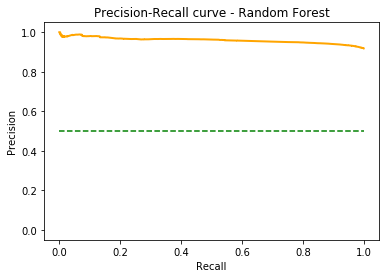

In [21]:
precision, recall, thresholds = precision_recall_curve(y_test, rf.predict_proba(X_test)[:,1])
precision_recall_auc_score = auc(recall, precision)
#fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
plt.plot(recall, precision,lw=2,c='orange')
#plt.plot([0,1],[0,1],c='blue',ls='--')
plt.plot([0,1], [0.5,0.5],c='green',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve - Random Forest');

print('<Random Forest Scores>')
print('Precision-Recall AUC: ',precision_recall_auc_score)

In [22]:
def interactive_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    model_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=100)
    sns.heatmap(model_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['Not Certified', 'Certified'],
           yticklabels=['Not Certified', 'Certified'])
    plt.title('Random Forest Confusion Matrix');
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

In [23]:
# Interactive confusion matrix with threshold sldier! 
interactive(lambda threshold: interactive_confusion_matrix(rf, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

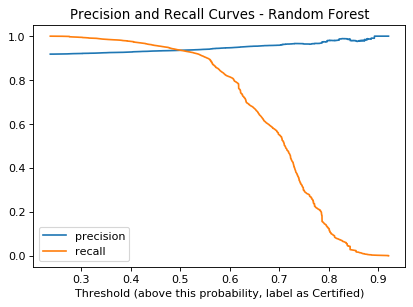

In [24]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, rf.predict_proba(X_test)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as Certified)');
plt.title('Precision and Recall Curves - Random Forest');

In [25]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [26]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = X.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)

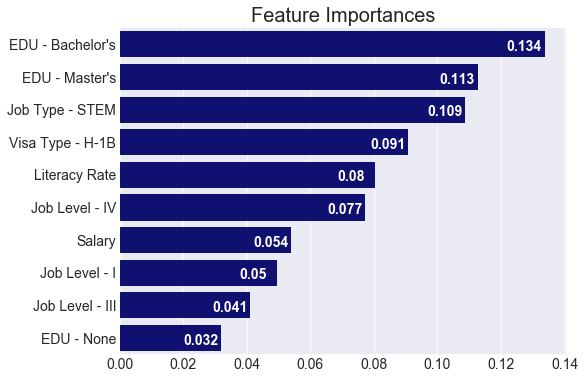

In [27]:
# Plot coefficients of significant features
plt.figure(figsize=(8,6))
plt.style.use('seaborn-darkgrid')
ax = sns.barplot(x='importance', y='index', data=feature_importances.reset_index().head(10), color='navy')
plt.yticks(np.arange(10),('EDU - Bachelor\'s', 'EDU - Master\'s', 'Job Type - STEM', 'Visa Type - H-1B', 'Literacy Rate',
                   'Job Level - IV', 'Salary', 'Job Level - I', 'Job Level - III', 'EDU - None'), size='14')
plt.xticks(size='14')
plt.ylabel('')
plt.xlabel('');
plt.title('Feature Importances', size='20');
for i, v in enumerate(feature_importances['importance'].head(10)):
    plt.text(v-0.012, i+0.2, str(round(v,3)), color='white', fontweight='bold', size='14')

In [ ]:
#rf_confusion = confusion_matrix(y_test, rf.predict(X_test))
#plt.figure(dpi=100)
#sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True,
#           xticklabels = ['Not Certified', 'Certified'],
#           yticklabels = ['Not Certified', 'Certified'])
#
#plt.xlabel('Predicted')
#plt.ylabel('Actual')
#plt.title('Random Forest Confusion Matrix');